<a href="https://colab.research.google.com/github/slajan01/cats_vs_dogs/blob/main/Kaggle_Dogs_vs_Cats_CNN_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import Statements (Grouped at the top as per good practice)
import os
import shutil
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing import image
from google.colab import files
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50, VGG16, VGG19, Xception, InceptionV3
from tensorflow.keras.layers import ReLU, LeakyReLU, ELU, PReLU

# Nahrání dat - Google Colab specific commands
files.upload()

# Handle Kaggle JSON file securely
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download and unzip dataset from Kaggle
!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition
!unzip -qq dogs-vs-cats-redux-kernels-edition.zip
!unzip -qq train.zip

# Unzip test dataset as well
!unzip -qq test.zip  # <--- Unzipping test.zip for predictions

# Zkopírování obrázků do testovacího, trénovacího a validačního adresáře
original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir, exist_ok=True)  # Create dirs if they don't exist
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            src = original_dir / fname
            dst = dir / fname
            if src.exists():  # Add check to avoid errors
                shutil.copyfile(src, dst)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

# Předzpracování dat (Data Preprocessing)
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(299, 299),
    batch_size=32,
    validation_split=0.2,  # Example of using validation_split
    subset="training",
    seed=123  # Always set seed for reproducibility
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(299, 299),
    batch_size=32
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(299, 299),
    batch_size=32
)

Saving kaggle.json to kaggle.json
100% 811M/814M [00:41<00:00, 23.6MB/s]
100% 814M/814M [00:41<00:00, 20.7MB/s]
Found 2000 files belonging to 2 classes.
Using 1600 files for training.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [2]:
# Load each pretrained model without its top layer
resnet_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
vgg16_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
vgg19_model = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
xception_model = tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
inceptionv3_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freeze the layers of each model to prevent retraining
resnet_model.trainable = False
vgg16_model.trainable = False
vgg19_model.trainable = False
xception_model.trainable = False
inceptionv3_model.trainable = False

# Data augmentation pipeline
data_augmentation = models.Sequential(
    [
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.2),  # Random rotation
        layers.RandomZoom(0.3),      # Random zoom
        layers.RandomContrast(0.2),  # Random contrast adjustment
        layers.RandomBrightness(0.2),  # Random brightness adjustment
        layers.RandomTranslation(0.2, 0.2),  # Random translation
    ]
)

# Create an input layer
input_layer = tf.keras.Input(shape=(299, 299, 3))

# Process the input through each model
augmented_input = data_augmentation(input_layer)

# Get the outputs from each model
resnet_output = resnet_model(augmented_input)
vgg16_output = vgg16_model(augmented_input)
vgg19_output = vgg19_model(augmented_input)
xception_output = xception_model(augmented_input)
inceptionv3_output = inceptionv3_model(augmented_input)

# Global pooling to reduce dimensionality
resnet_output = layers.GlobalAveragePooling2D()(resnet_output)
vgg16_output = layers.GlobalAveragePooling2D()(vgg16_output)
vgg19_output = layers.GlobalAveragePooling2D()(vgg19_output)
xception_output = layers.GlobalAveragePooling2D()(xception_output)
inceptionv3_output = layers.GlobalAveragePooling2D()(inceptionv3_output)

# Concatenate the outputs from all four models
ensemble_output = layers.concatenate([resnet_output, vgg16_output, vgg19_output, xception_output, inceptionv3_output])

x = layers.Flatten()(ensemble_output)
x = layers.Dense(256, kernel_regularizer=regularizers.l2(0.003))(x)
x = LeakyReLU(negative_slope=0.1)(x)
x = layers.Dropout(0.3)(x)
output = layers.Dense(1, activation='sigmoid')(x)

# Build and compile the ensemble model
ensemble_model = models.Model(inputs=input_layer, outputs=output)
ensemble_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Reduce learning rate on plateau callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.3, patience=3, min_lr=1e-7, verbose=1
)

# Training the model with callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath="ensemble_model.keras", save_best_only=True, monitor="val_loss"),
    reduce_lr
]

history = ensemble_model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 58s 518ms/step - accuracy: 0.5752 - loss: 6.4851 - val_accuracy: 0.8510 - val_loss: 1.9548 - learning_rate: 1.0000e-04
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 16s 318ms/step - accuracy: 0.6486 - loss: 3.4681 - val_accuracy: 0.9240 - val_loss: 1.5693 - learning_rate: 1.0000e-04
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 310ms/step - accuracy: 0.7432 - loss: 2.3443 - val_accuracy: 0.9390 - val_loss: 1.4079 - learning_rate: 1.0000e-04
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 308ms/step - accuracy: 0.7228 - loss: 2.0525 - val_accuracy: 0.9420 - val_loss: 1.3174 - learning_rate: 1.0000e-04
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 310ms/step - accuracy: 0.7520 - loss: 1.8457 - val_accuracy: 0.9420 - val_l

63/63 ━━━━━━━━━━━━━━━━━━━━ 26s 272ms/step - accuracy: 0.9724 - loss: 0.7525
Test accuracy: 0.972
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 0.9762 - loss: 0.7264
Validation accuracy: 0.972


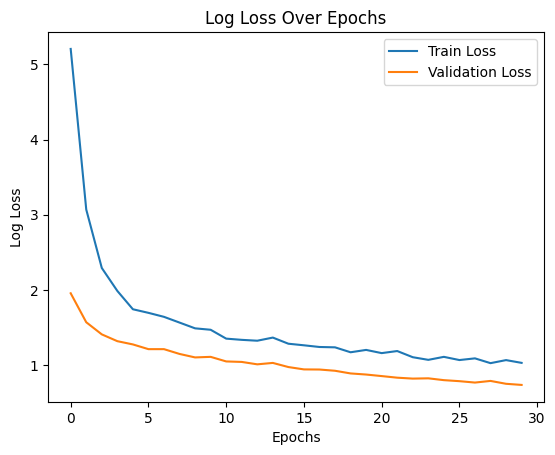

391/391 ━━━━━━━━━━━━━━━━━━━━ 73s 173ms/step
Your submission was successfully saved!


In [3]:
# Evaluate on test data
model = tf.keras.models.load_model("ensemble_model.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

val_loss, val_acc = model.evaluate(validation_dataset)
print(f"Validation accuracy: {val_acc:.3f}")

# Plot log loss over epochs
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Log Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.legend()
plt.show()

# Load sample_submission.csv
sample_submission = pd.read_csv("/content/sample_submission.csv")  # <--- Loading the sample submission file

# Test image preprocessing
def load_and_preprocess_image(img_path, target_size=(299,299)):
    img = Image.open(img_path)
    img = img.resize(target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    # Use ResNet's preprocess_input function instead of manual normalization
    img_array = tf.keras.applications.resnet50.preprocess_input(img_array)

    return img_array

# Load and process test images for predictions
test_dir = 'test'
test_images = []
image_ids = []

for img_name in os.listdir(test_dir):
    img_path = os.path.join(test_dir, img_name)
    img_array = load_and_preprocess_image(img_path)
    test_images.append(img_array)
    image_ids.append(img_name)

test_images = np.vstack(test_images)

# Make predictions on test images
predictions = model.predict(test_images)

# Convert predictions to binary values
predictions_1d = (predictions > 0.5).astype(int).flatten()

# Ensure image names and submission IDs are aligned
# Extract numeric part of image filenames to match the submission file
# Assuming filenames are in the format like '1.jpg', '2.jpg', etc.
image_ids_clean = [int(os.path.splitext(img_name)[0]) for img_name in image_ids]

# Create a DataFrame with image IDs and predictions
predictions_df = pd.DataFrame({'id': image_ids_clean, 'label': predictions_1d})

# Merge predictions with the sample_submission to ensure correct ordering
output = sample_submission[['id']].merge(predictions_df, on='id', how='left')

# Save results for submission
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")